In [374]:
import numpy as np # used for working on array
import matplotlib.pyplot as plt # used for ploting figures
from matplotlib.patches import Ellipse # used to create ellipse
import seaborn as sns # used for plotting figures
import pandas as pd # used for working with dataframes
import random # used to creating random numbers
from sklearn.metrics import roc_auc_score as AUC

In [375]:
########## Training Distribution ###############
nTr_Class1=100
nTr_Class2=100

nTs_Class1=100
nTs_Class2=100

### 2-D Data

In [376]:
# This function is used to create an ellipse with covariance matrix, centre, and nstd. 

def get_cov_ellipse(cov, centre, nstd, **kwargs):
    """
    Return a matplotlib Ellipse patch representing the covariance matrix
    cov centred at centre and scaled by the factor nstd.

    """
    # Find and sort eigenvalues and eigenvectors into descending order
    eigvals, eigvecs = np.linalg.eigh(cov)
    order = eigvals.argsort()[::-1]
    eigvals, eigvecs = eigvals[order], eigvecs[:, order]

    # The anti-clockwise angle to rotate our ellipse by 
    vx, vy = eigvecs[:,0][0], eigvecs[:,0][1]
    theta = np.arctan2(vy, vx)

    # Width and height of ellipse to draw
    width, height = 2 * nstd * np.sqrt(eigvals)
    return Ellipse(xy=centre, width=width, height=height,
                   angle=np.degrees(theta), **kwargs)

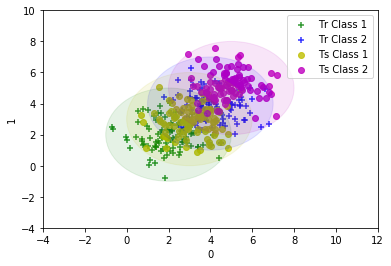

In [378]:
##########  Training ########## 
Tr_Mu1 = [2,2]
Tr_Cov1 = np.eye(2)
Tr_d1 = np.random.multivariate_normal(Tr_Mu1, Tr_Cov1, nTr_Class1)

Tr_Mu2 = [4,4]
Tr_Cov2 = np.eye(2)
Tr_d2 = np.random.multivariate_normal(Tr_Mu2, Tr_Cov2, nTr_Class2)

Tr_X_array=np.concatenate((Tr_d1,Tr_d2), axis=0)
Tr_X=pd.DataFrame(Tr_X_array)

##### Y Groud Truth (Labels)

zz=np.zeros((nTr_Class1,1), dtype=int)
on=np.ones((nTr_Class2,1), dtype=int)
Tr_Y=np.concatenate((zz,on), axis=0) 
Tr_Y=pd.DataFrame(Tr_Y)
#Tr_Y=Tr_Y.ravel()

##########  Testing ########## 
Ts_Mu1 = [3,3]
Ts_Cov1 = np.eye(2)
Ts_d1 = np.random.multivariate_normal(Ts_Mu1, Ts_Cov1, nTs_Class1)

Ts_Mu2 = [5,5]
Ts_Cov2 = np.eye(2)
Ts_d2 = np.random.multivariate_normal(Ts_Mu2, Ts_Cov2, nTs_Class2)

Ts_X_array=np.concatenate((Ts_d1,Ts_d2), axis=0)
Ts_X=pd.DataFrame(Ts_X_array)

##### Y Groud Truth (Labels)

zz=np.zeros((nTs_Class1,1), dtype=int)
on=np.ones((nTs_Class2,1), dtype=int)
Ts_Y=np.concatenate((zz,on), axis=0) 
Ts_Y=pd.DataFrame(Ts_Y)
#Ts_Y=Ts_Y.ravel()

########## Plot ########## 

# use the function regplot to make a scatterplot
ax1=sns.regplot(x=Tr_X.iloc[0:100,0], y=Tr_X.iloc[0:100,1], marker="+", fit_reg=False, color="g", label="Tr Class 1")
e1 = get_cov_ellipse(Tr_Cov1, Tr_Mu1, 3,color="g", alpha=0.1)
ax1.add_artist(e1)

ax2=sns.regplot(x=Tr_X.iloc[101:200,0], y=Tr_X.iloc[101:200,1],  marker="+", fit_reg=False, color="b", label="Tr Class 2")
e2 = get_cov_ellipse(Tr_Cov2, Tr_Mu2, 3, color="b", alpha=0.1)
ax2.add_artist(e2)

# use the function regplot to make a scatterplot
ax3=sns.regplot(x=Ts_X.iloc[0:100,0], y=Ts_X.iloc[0:100,1],fit_reg=False, color="y", marker="o", label="Ts Class 1")
e3 = get_cov_ellipse(Ts_Cov1, Ts_Mu1, 3, color="y", alpha=0.1)
ax3.add_artist(e3)

ax4=sns.regplot(x=Ts_X.iloc[101:200,0], y=Ts_X.iloc[101:200,1],fit_reg=False, color="m", marker="o", label="Ts Class 2")
e4 = get_cov_ellipse(Ts_Cov2, Ts_Mu2, 3,color="m", alpha=0.1)
ax4.add_artist(e4)

plt.ylim(-4,10)
plt.xlim(-4, 12)
plt.legend()
plt.show()

## Learning without Domain Adaptation

In [379]:
## Training 

from sklearn import svm
clf = svm.SVC(C=1.0, kernel='linear')
clf.fit(Tr_X,np.ravel(Tr_Y))


SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [380]:
## Testing 
from sklearn import metrics
Y_hat=clf.predict(np.array(Ts_X))
metrics.accuracy_score(Y_hat, Ts_Y)

0.745

## Learning with Domain Adaptation in Passive Approach

In [381]:
## Training 
from sklearn import svm
clf = svm.SVC(C=1.0, kernel='linear')
clf.fit(Tr_X,np.ravel(Tr_Y))

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [382]:
y_pred = [] ## An empty array to store the Final predicited values
Ts=np.ravel(Ts_Y)
win_size = 10

for idx, val in enumerate(Ts):
    if idx % win_size == 0:
        x=Ts_X.iloc[idx:idx+10,].values # Test X Block
        y=Ts_Y.iloc[idx:idx+10].values # Test Y Block
        y_hat=clf.predict(x) # Prediction of a block
        print(y_hat) # Print the predicted values
        y_pred=np.append(y_pred, y_hat, axis=0) # Append the predicted values to the final predicted Array
        y_hat=pd.DataFrame(y_hat)
        tmp_array_X = []
        tmp_array_Y = []
        y_hat=y_hat.values
        for idxx, vall in enumerate(y_hat): # Check predicted values with true Labels
            if y[idxx] == y_hat[idxx]: # If true, append them, otherwise ignore
                tmp_array_X.append(x_temp[idxx])
                tmp_array_Y.append(y_temp[idxx])
        #print(np.shape(tmp_array_X)) # To check if correct labels were added or not
        # Add data correct predicted data to the training data set and retrain the classifier
        Tr_X=pd.concat([Tr_X, pd.DataFrame(tmp_array_X)], ignore_index=True)
        Tr_Y=pd.concat([Tr_Y, pd.DataFrame(tmp_array_Y)], ignore_index=True)
        ## Re-Training of classifier (Domain Adaptation in Passive approach)
        from sklearn import svm
        clf = svm.SVC(C=1.0, kernel='linear')
        clf.fit(Tr_X,np.ravel(Tr_Y))
        print(np.shape(Tr_X))
        print(np.shape(Tr_Y))

[1 1 0 0 0 0 1 0 0 1]
(206, 2)
(206, 1)
[1 1 1 0 1 0 0 1 0 1]
(210, 2)
(210, 1)
[1 0 0 0 1 1 0 1 1 0]
(215, 2)
(215, 1)
[0 0 0 0 1 1 1 0 0 0]
(222, 2)
(222, 1)
[0 1 0 0 0 1 0 0 0 0]
(230, 2)
(230, 1)
[0 0 0 1 0 1 0 1 0 1]
(236, 2)
(236, 1)
[1 0 1 1 1 0 0 0 1 0]
(241, 2)
(241, 1)
[1 0 0 0 1 0 0 1 1 0]
(247, 2)
(247, 1)
[0 1 0 1 0 0 0 1 0 0]
(254, 2)
(254, 1)
[0 1 1 1 0 1 0 0 0 1]
(259, 2)
(259, 1)
[1 1 1 1 1 1 1 1 1 1]
(269, 2)
(269, 1)
[1 1 1 1 1 1 1 1 1 1]
(279, 2)
(279, 1)
[1 1 1 1 1 1 1 1 1 1]
(289, 2)
(289, 1)
[1 1 1 1 1 1 1 1 1 1]
(299, 2)
(299, 1)
[1 1 1 1 1 1 1 1 1 1]
(309, 2)
(309, 1)
[1 1 1 1 1 1 1 1 1 1]
(319, 2)
(319, 1)
[1 1 1 1 1 1 1 1 1 1]
(329, 2)
(329, 1)
[1 1 1 1 1 1 1 1 1 1]
(339, 2)
(339, 1)
[1 1 1 1 1 1 1 1 1 1]
(349, 2)
(349, 1)
[1 1 1 1 1 1 1 1 1 1]
(359, 2)
(359, 1)


In [383]:
# Get the Final Accuracy after domain adaptation
metrics.accuracy_score(y_pred, Ts_Y)

0.795